In [1]:
cd ..

C:\Users\elliot\git\RobotCode2019\vision


In [2]:
import cv2
import numpy
import math
from enum import Enum
import time
import struct
from collections import namedtuple
from IPython.display import Image
from matplotlib import pyplot as plt
from pi.pi_pipeline import DeliveryUndistorter, GripPipelineWhiteTape

In [3]:
# Camera constants
horiz_FOV = 57.64 # ELP 57.64, LifeCam 25.18 * 2, XBox 41.97
vert_FOV = 42.36 # ELP 42.36, LifeCam 52.696, XBox 32.67
height = 35.75
vert_angle = 47 # How far down the camera is pointed
horiz_angle = 0 # How far to the right the camera is pointed
horiz_offset = 0 # How far to the right the camera is shifted
width_pixels = 320
height_pixels = 240

# Target constants
target_bottom_height = 26.17519
target_farthest_corner_height = 26.67595 # Height from ground to farthest left/right corners
target_half_width = 7.355315 # Distance from center of pair to edge of target

# Calculated constants
half_height_pixels = height_pixels / 2
half_width_pixels = width_pixels / 2
horiz_tan = math.tan(math.radians(horiz_FOV/2))
vert_tan = math.tan(math.radians(vert_FOV/2))
target_half_width_squared = target_half_width**2
target_width = target_half_width*2
target_width_squared = target_width**2

def _calc_angle_h(pixel_x, distance):
    """
    Calculate angle to half_height_pixelspixel x coordinate. Distance to point required in case horiz_offset != 0.
    """
    angle_h =  (math.degrees(
            math.atan(((pixel_x-half_width_pixels)*horiz_tan
            /half_width_pixels)))) - horiz_angle
    if horiz_offset != 0:
        horiz_distance = math.tan(math.radians(angle_h)) * distance
        horiz_distance += horiz_offset
        angle_h = math.degrees(math.atan(horiz_distance/distance))
    return angle_h
def _calc_distance(pixel_y, point_height=target_bottom_height):
    """
    Calculate distance and angle v. Returns (distance, angle_v)
    """
    angle_v = (math.degrees(
            math.atan(((pixel_y-half_height_pixels)*-1*vert_tan
            /half_height_pixels)))) - vert_angle
    distance = abs(point_height-height) / math.tan(math.radians(abs(angle_v)))
    return (distance, angle_v)

def _gen_tape_box(box_points):
        new_box = [-1] * 4
        sorted_box = sorted(box_points, key=lambda point: point[0]) # X pos sort
        new_box[0] = sorted_box[0] # Left
        new_box[3] = sorted_box[3] # Right
        sorted_box = sorted(box_points, key=lambda point: point[1]) # Y pos sort
        new_box[1] = sorted_box[3] # Bottom
        new_box[2] = sorted_box[0] # Top
        return TapeBox(*new_box)

def _gen_boxes(contours):
    boxes = [cv2.minAreaRect(contour) for contour in contours]
    # minAreaRect returns ((x, y), (width, height), angle), angle is -90 to 0
    # see https://stackoverflow.com/questions/15956124/minarearect-angles-unsure-about-the-angle-returned
    return [[cv2.boxPoints(box), box] for box in boxes] # Create [corner coords, arearect] lists

# len of line sqrt((x2-x1)^2 + (y2-y1))^2)
def _line_len(point1, point2): 
    return numpy.sqrt((point2[0]-point1[0])**2 + (point2[1] - point1[1]) **2)

TapeBox = namedtuple("TapeBox", ["left", "bottom", "top", "right"])

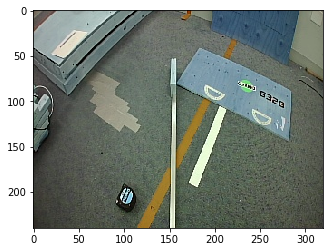

In [4]:
image = cv2.imread("C:\\Users\\elliot\\git\\RobotCode2019\\vision\\images\\ELP\\angle20wrong.jpg")
plt.imshow(image)

In [5]:
pipeline = GripPipelineWhiteTape()
undistorter = DeliveryUndistorter()

Delivery All-Good ROI: (0, 0, 320, 240)


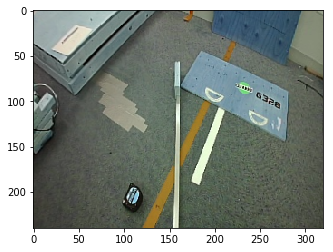

In [6]:
image_undistorted = undistorter.undistort(image)
plt.imshow(image_undistorted)

In [7]:
cv2.imwrite("images\\ELP\\capture-undistorted.jpg", image_undistorted)

True

[87.58408615362211]
[[[173.60805  188.7273  ]
  [182.86058  192.01709 ]
  [202.94957  106.204285]
  [212.2021   109.49408 ]]]


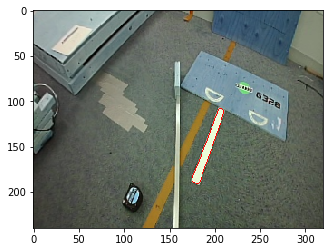

In [8]:
pipeline.process(image_undistorted)
contours = pipeline.filter_contours_output
boxes = _gen_boxes(pipeline.filter_contours_output)
boxes = [[_gen_tape_box(box[0]), box[1]] for box in boxes]
# Find box with longest left-top distance (tape on floor has longest edge)
boxes.sort(key=lambda box: max(_line_len(box[0].left, box[0].top), _line_len(box[0].right, box[0].top)), reverse=True)
print([max(_line_len(box[0].left, box[0].top), _line_len(box[0].right, box[0].top)) for box in boxes])
contours_draw = numpy.array([numpy.array(box[0]) for box in boxes])
print(contours_draw)
plt.imshow(cv2.drawContours(image_undistorted.copy(), pipeline.filter_contours_output, -1, (255,0,0), 1))

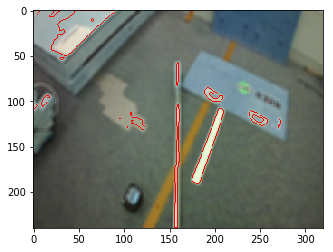

In [9]:
plt.imshow(cv2.drawContours(pipeline.blur_output.copy(), pipeline.find_contours_output, -1, (255,0,0), 1))

122


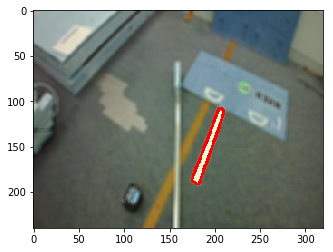

In [10]:
contour = pipeline.find_contours_output[8]
print(len(contour))
plt.imshow(cv2.drawContours(pipeline.blur_output.copy(), [contour], -1, (255,0,0), 2))

In [11]:
point1 = boxes[0][0].top
# Point 2 is the second highest point
point2 = sorted(boxes[0][0], key=lambda point: point[1])[1]
# Average the two far end of tape points to get the center of tape end point
point = ((point1[0] + point2[0])/2, (point1[1] + point2[1])/2)
point

(207.57583618164062, 107.84918212890625)

In [12]:
# Tape end is on ground and _calc_distance default point height is for retro tape
distance = _calc_distance(point[1], point_height=0)[0]
print("Angle:", _calc_angle_h(point[0], distance))
print("Distance", distance)

Angle: 9.291512305382964
Distance 36.059325977047926
